In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.decomposition import PCA
from google.colab import drive

#mount drive
drive.mount('/content/drive')

#change directory
#current_directory=os.getcwd()
#os.chdir(current_directory)
%cd /content/drive/MyDrive/Colab Notebooks/SecurityProject

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/SecurityProject


In [2]:
#available windows
windows=[10, 60, 180, 600]

TCP_FILE_NAME='data_tcp'
UDP_FILE_NAME='data_udp'
ICMP_FILE_NAME='data_icmp'

#features
feature1 = 'ts'
feature2 = 'src_ip'
feature3 = 'src_port'
feature4 = 'dst_ip'
feature5 = 'dst_port'
feature6 = 'pck_len'
feature7 = 'tcp_flags'
feature8 = 'cluster'
feature9 = 'user'
feature10 = 'num_attack'
feature11 = 'first_port_scan'
feature12 = 'ip_diff'
feature13 = 'port_diff'
feature14 = 'range_ip'
feature15 = 'range_port'
feature16 = 'ip_medium'
feature17 = 'ip_std'
feature18 = 'port_medium'
feature19 = 'port_std'
feature20 = 'pck_medium'
feature21 = 'pck_std'

In [3]:
def choose_window(proto):
  print("Choose a time window for", proto)

  user_input=False
  while not (user_input):
    for j in range(0, len(windows)):
      print(str(j+1)+") "+str(windows[j]))

    try:
      user_input = int(input(""))

      if user_input >=1 and user_input <= len(windows):
        window_chosen=windows[user_input-1]
      else:
        print ("\nChoose Well\n")
        user_input=False

    except ValueError:
      print('\nInvalid number!\n')

  return window_chosen


#read data 
def read_data(fname):
  stream = os.popen("find . -name '%s'" % fname)
  fpath = stream.read()[:-1]
  data_original= pd.read_csv(fpath)

  return data_original


#set optimal cluster parameters
class Cluster_parameters:
    def __init__(self, eps, min_samples): 
        self.eps = eps
        self.min_samples = min_samples


#display created clusters
def print_clusters(df, labels, num_cluster=10, title=''):
  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(df)
  principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
  labels_df = pd.DataFrame(labels, columns=['cluster']) 
  final_df = pd.concat([principalDf, labels_df[['cluster']]], axis = 1)
  final_df.dropna(inplace=True)
  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(1,1,1) 
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title(title, fontsize = 20)
  #-1 for noisy samples
  targets = [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
  colors = ['k', 'r', 'g', 'b', 'y', 'c', 'm', 'orchid', 'darkorange', 'darkblue', 'pink']
  i=1
  for target, color in zip(targets,colors):
      indicesToKeep = final_df['cluster'] == target
      ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
                , final_df.loc[indicesToKeep, 'principal component 2']
                , c = color
                , s = 50)
      i=i+1
      if i>num_cluster:
        break
  ax.legend(targets)
  ax.grid()
  

# calculate clusters
def cluster(df, features, _eps=0.3, _min_samples=10):
  #rescaling dataset and setting feature
  df_rescaled = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns)

  #clusters creation with DBSCAN
  dbs = DBSCAN(_eps, _min_samples)

  labels = dbs.fit_predict(df_rescaled[features])
  n_cluster = len(set(labels))
  #label assignment 
  df_rescaled['cluster'] = labels

  #calculate clusters' size
  detail = df_rescaled.groupby(['cluster']).size()

  return df_rescaled, labels, detail, n_cluster

# TCP Cluster

In [35]:
#choose time window
tcp_window=choose_window("TCP")

#set file name 
file_tcp=TCP_FILE_NAME+"_"+str(tcp_window)+".csv"

#read data 
data_tcp_original=read_data(file_tcp)

#drop duplicates
data_tcp_rm = data_tcp_original.drop_duplicates(subset=['user'])

Choose a time window for TCP
1) 10
2) 60
3) 180
4) 600
3


In [36]:
tcp_parameters={}

#set parameters  #tutti valori alti però ho 2 cluster
tcp_parameters[10]=Cluster_parameters(10,300)
tcp_parameters[60]=Cluster_parameters(10,300)
tcp_parameters[180]=Cluster_parameters(10,300)
tcp_parameters[600]=Cluster_parameters(10,300)

In [37]:
#features for clustering
tcp_features=[feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21]

if tcp_window in tcp_parameters.keys():
  actual_param=tcp_parameters[tcp_window]
  rescaled_data_tcp_rm, tcp_labels, detail, n_cluster_tcp=cluster(data_tcp_rm, tcp_features, actual_param.eps, actual_param.min_samples)
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  rescaled_data_tcp_rm, tcp_labels, detail, n_cluster_tcp=cluster(data_tcp_rm, tcp_features)

print("TCP cluster's details\n", detail)

TCP cluster's details
 cluster
-1      108
 0    24369
dtype: int64



*Performance* 



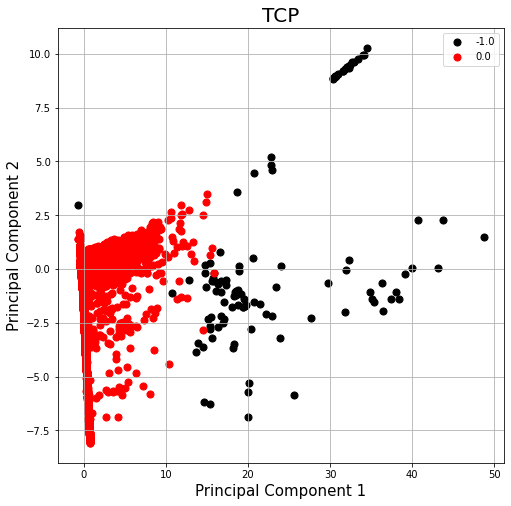

In [38]:
#print clusters
print_clusters(rescaled_data_tcp_rm[tcp_features], tcp_labels, n_cluster_tcp, "TCP")

In [39]:
score_tcp = silhouette_score(rescaled_data_tcp_rm[tcp_features],tcp_labels)
print(score_tcp)

0.906264590327502


In [9]:
#definitive cluster assignment
data_tcp_rm['cluster']=tcp_labels

# UDP Cluster

In [10]:
#choose time window
udp_window=choose_window("UDP")

#set file name 
file_udp=UDP_FILE_NAME+"_"+str(udp_window)+".csv"

#read data 
data_udp_original=read_data(file_udp)

#drop duplicates
data_udp_rm = data_udp_original.drop_duplicates(subset=['user'])

Choose a time window for UDP
1) 10
2) 60
3) 180
4) 600
1


In [11]:
udp_parameters={}

#set parameters 
udp_parameters[10]=Cluster_parameters(3,5)  
udp_parameters[60]=Cluster_parameters(3,5)  
udp_parameters[180]=Cluster_parameters(3,5)
udp_parameters[600]=Cluster_parameters(3,5)

In [12]:
#features for clustering
udp_features=[feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21]

if udp_window in udp_parameters.keys():
  actual_param=udp_parameters[udp_window]
  rescaled_data_udp_rm, udp_labels, detail, n_cluster_udp=cluster(data_udp_rm, udp_features, actual_param.eps,actual_param.min_samples)
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  rescaled_data_udp_rm, udp_labels, detail, n_cluster_udp=cluster(data_udp_rm, udp_features)

print("UDP cluster's details\n", detail)

UDP cluster's details
 cluster
-1      18
 0    3815
 1      33
dtype: int64


*Performance*

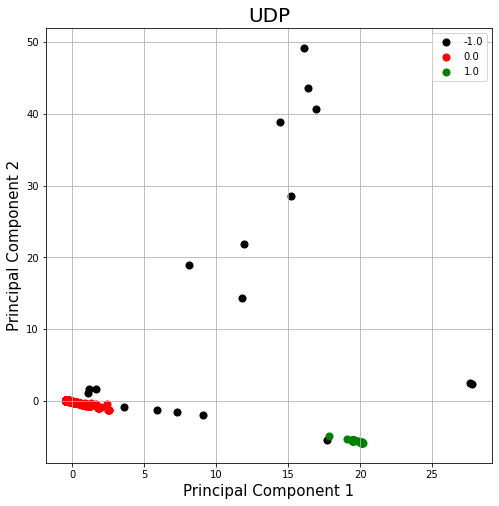

In [13]:
#print clusters
print_clusters(rescaled_data_udp_rm[udp_features], udp_labels, n_cluster_udp, "UDP")

In [14]:
score_udp = silhouette_score(rescaled_data_udp_rm[udp_features],udp_labels)
print(score_udp)

0.8923968122046592


In [15]:
#definitive cluster assignment
data_udp_rm['cluster']=udp_labels

# ICMP Cluster

In [16]:
#choose time window
icmp_window=choose_window("ICMP")

#set file name 
file_icmp=ICMP_FILE_NAME+"_"+str(icmp_window)+".csv"

#read data 
data_icmp_original=read_data(file_icmp)

#drop duplicates
data_icmp_rm = data_icmp_original.drop_duplicates(subset=['user'])

Choose a time window for ICMP
1) 10
2) 60
3) 180
4) 600
2


In [17]:
icmp_parameters={}

#set parameters 
icmp_parameters[10]=Cluster_parameters(3,5)
icmp_parameters[60]=Cluster_parameters(3,5) 
icmp_parameters[180]=Cluster_parameters(3,5)   
icmp_parameters[600]=Cluster_parameters(3,5)

In [18]:
#features for clustering
icmp_features=[feature10,feature12,feature14,feature16,feature17,feature20,feature21]

if icmp_window in icmp_parameters.keys():
  actual_param=icmp_parameters[icmp_window]
  rescaled_data_icmp, icmp_labels, detail, n_cluster_icmp=cluster(data_icmp_rm, icmp_features, actual_param.eps,actual_param.min_samples)
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  rescaled_data_icmp, icmp_labels, detail, n_cluster_icmp=cluster(data_icmp_rm, icmp_features)

print("ICMP cluster's details\n", detail)

ICMP cluster's details
 cluster
-1      2
 0    168
dtype: int64


*Performance*

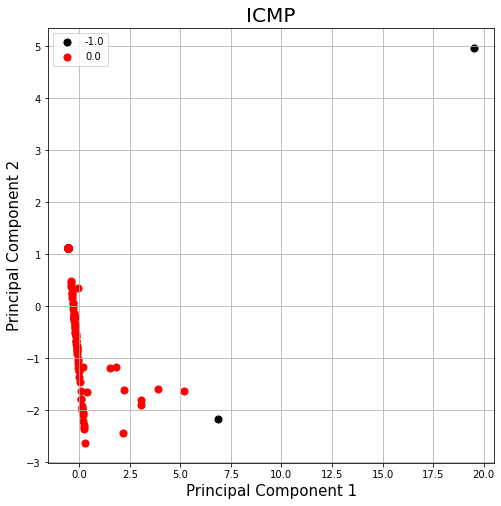

In [19]:
#print clusters
print_clusters(rescaled_data_icmp[icmp_features], icmp_labels, n_cluster_icmp, "ICMP")

In [20]:
score_icmp = silhouette_score(rescaled_data_icmp[icmp_features], icmp_labels)
print(score_icmp)

0.8605852957146765


In [21]:
#definitive cluster assignment
data_icmp_rm['cluster']=icmp_labels

#Old Data

What was done allowed to extract knowledge from the original dataset? Could the identified clusters be identified even without previous data manipulation?

In [22]:
def set_original_labels(df_new, df_old):
  cluster = []
  map_user = {}
  for index,row in df_new.iterrows():
    map_user[row['user']] = row['cluster']
  for index,row in df_old.iterrows():
    cluster.append(map_user[row['user']])
  cluster_np = np.asarray(cluster)
  cluster = cluster_np.reshape((cluster_np.size,1))
  rescaled_data = pd.DataFrame(StandardScaler().fit_transform(df_old), columns=df_old.columns)
  rescaled_data['cluster'] = cluster 

  return rescaled_data

TCP

Score TCP:  0.09743848794296112


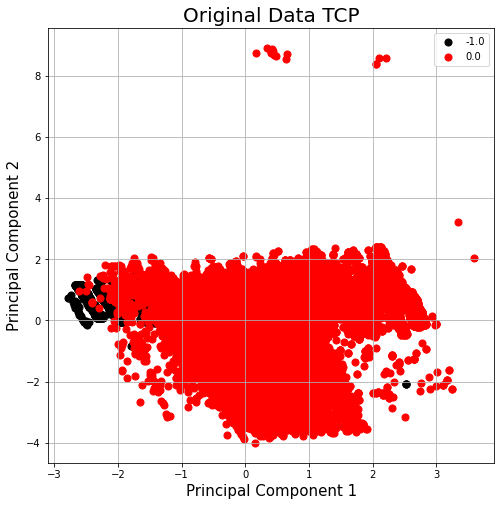

In [23]:
old_data_tcp = set_original_labels(data_tcp_rm, data_tcp_original)

old_tcp_features=[feature1, feature2, feature3, feature4, feature5, feature6, feature7]

#evaluating clustering perfomances
score_tcp = silhouette_score(old_data_tcp[old_tcp_features], old_data_tcp['cluster'])
print("Score TCP: ", score_tcp)

#print clusters TCP 
print_clusters(old_data_tcp[old_tcp_features], old_data_tcp['cluster'], n_cluster_tcp, "Original Data TCP")

UDP

Score UDP:  0.11998440814772787


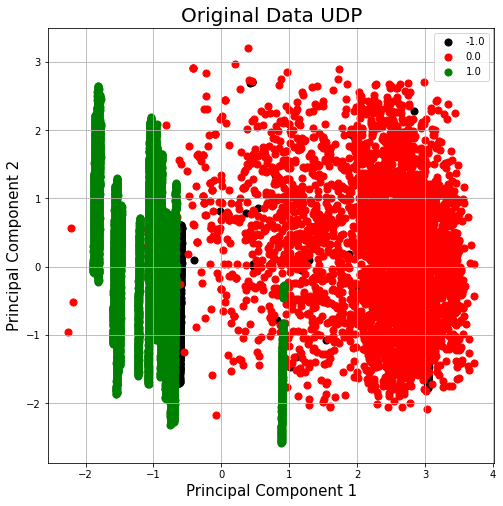

In [24]:
old_data_udp = set_original_labels(data_udp_rm, data_udp_original)

old_udp_features=[feature1, feature2, feature3, feature4, feature5, feature6]

#evaluating clustering perfomances 
score_udp = silhouette_score(old_data_udp[old_udp_features],old_data_udp['cluster'])
print("Score UDP: ", score_udp)

#print clusters UDP 
print_clusters(old_data_udp[old_udp_features], old_data_udp['cluster'], n_cluster_udp, "Original Data UDP")


ICMP

Score ICMP:  0.4093913476760177


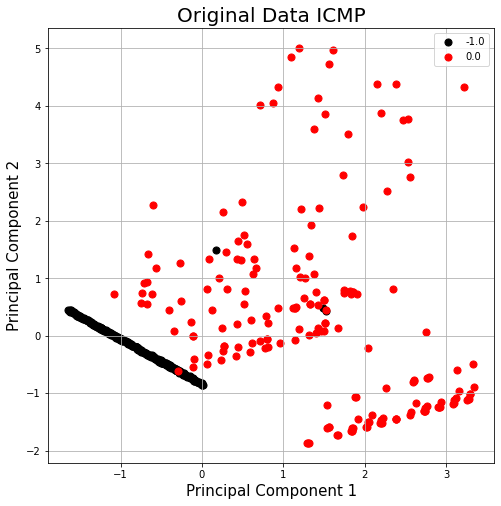

In [25]:
old_data_icmp = set_original_labels(data_icmp_rm, data_icmp_original)

old_icmp_features=[feature1, feature2, feature4, feature6]

#evaluating clustering perfomances 
score_icmp = silhouette_score(old_data_icmp[old_icmp_features],old_data_icmp['cluster'])
print("Score ICMP: ",score_icmp)

#print clusters ICMP (old data)
print_clusters(old_data_icmp[old_icmp_features],old_data_icmp['cluster'], n_cluster_icmp, "Original Data ICMP")


# Early Classification Performance

In [26]:
def get_accuracy_early_classification(df, partition):
  true_label = df['cluster'] 
  data_cluster = df.loc[(df['cluster'] == partition)]
  port_cluster = data_cluster['first_port_scan'].drop_duplicates().tolist()
  unlabeled_data = df.drop(['cluster'],axis=1)
  pred_label = []
  for index,row in df.iterrows():
    if row['dst_port'] in port_cluster:
      pred_label.append(partition)
    else:
      pred_label.append(-1)
  pred_label_np = np.asarray(pred_label)
  pred_label_np = pred_label_np.reshape((pred_label_np.size,1))    
  for label in true_label:
    if label != partition:
      label = -1
  accuracy =   accuracy_score(true_label,pred_label_np)
  return accuracy 

TCP

In [27]:
print('Accuracy for TCP')
for i in range (0,n_cluster_tcp):
  accuracy = get_accuracy_early_classification(data_tcp_rm, i)
  print('modus operandi',i,': ',accuracy)

Accuracy for TCP
modus operandi 0 :  0.9985292315234711
modus operandi 1 :  0.004412305429586959


UDP

In [28]:
print('Accuracy for UDP')
for i in range (0,n_cluster_udp):
  accuracy = get_accuracy_early_classification(data_udp_rm, i)
  print('modus operandi',i,': ',accuracy)

Accuracy for UDP
modus operandi 0 :  0.9875840662183135
modus operandi 1 :  0.013191929643041904
modus operandi 2 :  0.0046559751681324365


In [29]:
data_icmp_rm.cluster.unique()

array([ 0, -1])